In [1]:
import numpy as np
from casadi import *
import casadi as cs
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
import itertools 
from time import perf_counter
import sympy as sym
from IPython.display import display, Math

In [2]:
# x0 = np.random.rand(6*3,1)
x0 = np.array([0.1, 0.1, 1.0, 0.1, 0.1, 0.1])
xf = np.array([1.2, 1.2, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000
g = 9.8

u_ref = np.array([0,0,g])
N = 100

opti = Opti()

dt = 0.05

In [3]:
X = opti.variable(6,N+1)
U = opti.variable(3,N)

In [4]:
g = 9.81

In [5]:
f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)

In [6]:
for k in range(N): #loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

    opti.subject_to(X[:,k+1]==x_next) # close the gaps

In [7]:
total_stage_cost = 0
for j in range(X.shape[1]-1):
    for i in range(X.shape[0]):
        total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

for j in range(U.shape[1]-1):
    for i in range(U.shape[0]):
        total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

#Quadratic terminal cost:
total_terminal_cost = 0
# for j in range(X.shape[1]):
for i in range(X.shape[0]):
    total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])

In [8]:
objective = total_terminal_cost + total_stage_cost

In [9]:
opti.minimize(objective) 

In [10]:
opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
opti.subject_to(0.4<=X[2,:])

opti.subject_to(X[0,:]<=3) # p_x is limited
opti.subject_to(-3<=X[0,:])

opti.subject_to(X[1,:]<=3) # p_y is limited
opti.subject_to(-3<=X[1,:])

opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
opti.subject_to(-np.pi/6<=U[0,:])

opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
opti.subject_to(-np.pi/6<=U[1,:])

opti.subject_to(U[2,:]<=25) # tau is limited
opti.subject_to(0<=U[2,:]) #minimum force 

# opti.subject_to(X[0:3,-1] == xf[0:3])
#equality constraints:
opti.subject_to(X[:,0] == x0)
t0 = perf_counter()
opti.solver('ipopt');
sol = opti.solve()
tf = perf_counter()

print(f'total run time is {tf-t0} seconds')



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2106
Number of nonzeros in inequality constraint Jacobian.:     1206
Number of nonzeros in Lagrangian Hessian.............:      905

Total number of variables............................:      906
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality co

In [11]:
X_trj = sol.value(X)
U_trj = sol.value(U)

Text(0.5, 0.92, 'Trajectory from one-shot optimization')

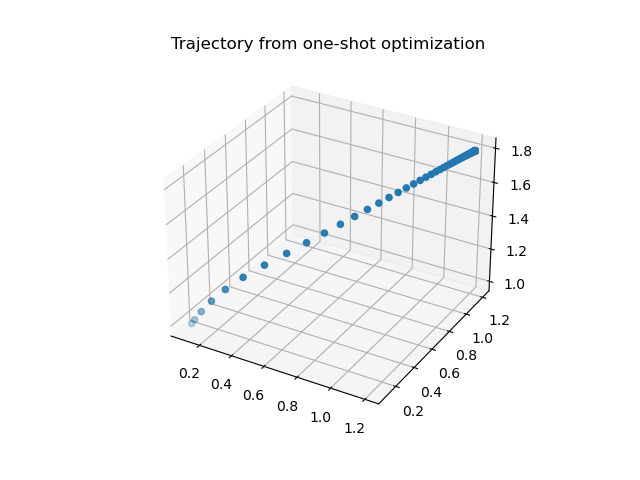

In [12]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_trj[0,:],X_trj[1,:],X_trj[2,:])
ax.set_title('Trajectory from one-shot optimization')

In [13]:
pos_err = np.linalg.norm(X_trj[0:3,-1]-xf[0:3])
pos_err

5.2727072380359054e-06

## Run it in receding-horizon

In [14]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]-1):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost
    # return total_stage_cost

In [15]:
x0 = np.array([0.5, 0.5, 1.0, 0.0, 0.0, 0.0])
xf = np.array([1.3, 1.1, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000

# u_ref = np.zeros((3,1))
u_ref = np.array([0,0,9.8])

In [16]:
n_agents = 1
n_states = 6
n_inputs=  3

In [17]:
def solve_rhc(x0,xf,u_ref,N,Qf):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 100,"print_level":0}
    
    opti = Opti()
    M = 100 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    
    f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)
    
    dt = 0.05
    
    while (np.linalg.norm(x0[0:3]-xf[0:3]) > 0.1) and (i < M):
    
        X = opti.variable(6,N+1)
        U = opti.variable(3,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps

        opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
        opti.subject_to(0.4<=X[2,:])

        opti.subject_to(X[0,:]<=3) # p_x is limited
        opti.subject_to(-3<=X[0,:])

        opti.subject_to(X[1,:]<=3) # p_y is limited
        opti.subject_to(-3<=X[1,:])
        
        opti.subject_to(X[3,:] <=5) #Vx is limited
        opti.subject_to(0 <= X[3,:])
        
        opti.subject_to(X[4,:] <=5) #Vy is limited
        opti.subject_to(0 <= X[4,:])
        
        opti.subject_to(X[5,:] <=5) #Vz is limited
        opti.subject_to(0 <= X[5,:])

        opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
        opti.subject_to(-np.pi/6<=U[0,:])

        opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
        opti.subject_to(-np.pi/6<=U[1,:])

        opti.subject_to(U[2,:]<=20) # tau is limited
        opti.subject_to(0<=U[2,:]) #minimum force keeps the drone at hover

        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)

        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        x0 = sol.value(X)[:,1]
        u_sol = sol.value(U)[:,0]
        J_list.append(sol.value(cost_fun))
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        if abs(J_list[i]-J_list[i-1]) <= 1 :
            print(f'Terminated! at i = {i}')
            break
        
        
    return X_full,U_full, t

In [18]:
from time import perf_counter

In [19]:
N = 5
t0 = perf_counter()
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Qf)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  38.50us (  2.75us)        14
       nlp_g  |        0 (       0)  75.70us (  5.41us)        14
  nlp_grad_f  |        0 (       0)  52.90us (  3.53us)        15
  nlp_hess_l  |        0 (       0)  61.70us (  4.75us)        13
   nlp_jac_g  |        0 (       0)  83.30us (  5.55us)        15
       total  |  15.62ms ( 15.62ms)  13.48ms ( 13.48ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  39.80us (  2.49us)        16
       nlp_g  |        0 (       0) 109.90us (  6.87us)        16
  nlp_grad_f  |        0 (       0)  51.50us (  3.03us)        17
  nlp_hess_l  |        0 (       0)  92.60us (  6.17us)        15
   nlp_jac_g  |        0 (       0) 138.60us (  8.15us)        17
       total  |  31.25ms ( 31.25ms)  23.53ms ( 23.53ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

Text(0.5, 0.92, 'Trajectory with receding horizon')

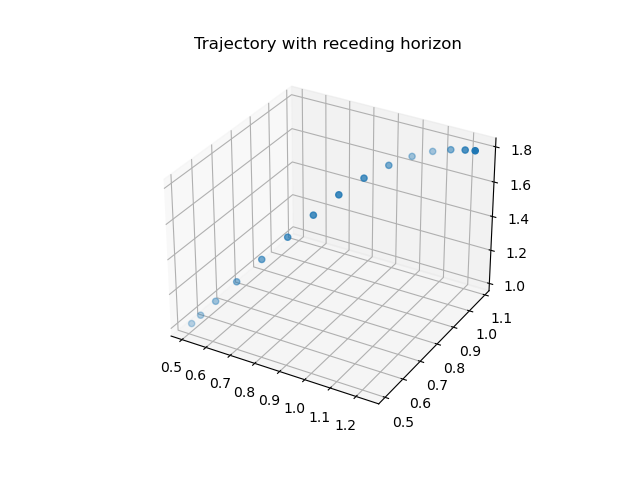

In [20]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x_trj[:,0],x_trj[:,1],x_trj[:,2])
ax.set_title('Trajectory with receding horizon')

In [21]:
pos_err = np.linalg.norm(x_trj[-1,0:3]-xf[0:3])

In [22]:
pos_err

0.0683399851879715